<a href="https://colab.research.google.com/github/StupidME2000/Custom-Cats-and-Dogs-Detection-Model---Yolov5/blob/main/Colab%20-%20Notebook/Custom_Object_Detection_YoloV5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Custom Object Detection with YOLOv5 and Novel Bounding Box Metric**  
### *AI Research Engineer Assessment Task*  

**GitHub:** [Custom-Cats-and-Dogs-Detection-Model](https://github.com/StupidME2000/Custom-Cats-and-Dogs-Detection-Model---Yolov5.git)

**Objective**:  
This notebook demonstrates an end-to-end custom object detection pipeline using YOLOv5, featuring:  
1. **Dataset preparation** (100 manually labeled images of cats/dogs)  
2. **Model training** with YOLOv5  
3. **Implementation of a novel bounding box similarity metric** combining:  
   - Intersection-over-Union (IoU)  
   - Aspect ratio alignment  
   - Center proximity  
   - Size similarity  
4. **Quantitative evaluation** against standard metrics (mAP, IoU)  


**Dataset**:  
- 30 cats | 30 dogs | 40 mixed scenes  
- Annotated via Label Studio → converted to YOLOv5 format  
- 90/10 train-val split  

**Expected Outputs**:  
- Trained model weights  
- Evaluation metrics (standard + custom)  
- Visual detection examples  


**Verify NVIDIA GPU Availability**

Make sure you're using a GPU-equipped machine by going to "Runtime" -> "Change runtime type" in the top menu bar, and then selecting one of the GPU options in the Hardware accelerator section. Click Play on the following code block to verify that the NVIDIA GPU is present and ready for training.

In [1]:
!nvidia-smi

Tue Mar 25 10:57:52 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

#Gather and Label Training Images

# Data Preparation

## Dataset Composition

For this custom object detection task, I created a balanced dataset of **100 images** with the following distribution:

- **30 images** containing only cats
- **30 images** containing only dogs  
- **40 images** containing both cats and dogs together

This composition ensures:
- Equal representation of both classes
- Sufficient examples of single-class scenarios
- Ample multi-object examples for robust detection

## Annotation Process

I used **Label Studio** (https://labelstud.io/) for manual annotation due to its:

1. **User-friendly interface** for drawing bounding boxes
2. **Flexible export formats** compatible with YOLOv5



#Upload Image Dataset and Prepare Training Data

##Upload images

Now I upload my custom labled dataset to the colob workspace

In [2]:
!pip install gdown

#downloading file from my drive
file_id = "1zTRxIZW0T73wcWd2Q61H5zkalVIaO6Y5"
!gdown --id {file_id} -O /content/data.zip

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1zTRxIZW0T73wcWd2Q61H5zkalVIaO6Y5
To: /content/data.zip
100% 24.4M/24.4M [00:00<00:00, 30.7MB/s]


##Split images into train and validation folders

In [3]:
# Unzip images to a custom data folder
!unzip -q /content/data.zip -d /content/custom_data

In [4]:
#downloading train_val_split.py from my drive
file_id = "1fisfjeucesQzW8awOlk-SFUHP72DGXwI"
!gdown --id {file_id} -O /content/train_val_split.py

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1fisfjeucesQzW8awOlk-SFUHP72DGXwI
From (redirected): https://drive.google.com/uc?id=1fisfjeucesQzW8awOlk-SFUHP72DGXwI&confirm=t&uuid=1e3af0fb-707e-468d-aeb2-ece456ca4e8a
To: /content/train_val_split.py
100% 2.87k/2.87k [00:00<00:00, 10.8MB/s]


Ultralytics requires a particular folder structure to store training data for models. Ultralytics requires a particular folder structure to store training data for models. The root folder is named “data”. Inside, there are two main folders:

*   **Train**: These are the actual images used to train the model. In one epoch of training, every image in the train set is passed into the neural network. The training algorithm adjusts the network weights to fit the data in the images.


*   **Validation**: These images are used to check the model's performance at the end of each training epoch.

In each of these folders is a “images” folder and a “labels” folder, which hold the image files and annotation files respectively.

This python script will automatically create the required folder structure and randomly move 90% of dataset to the "train" folder and 10% to the "validation" folder.

In [5]:
!python train_val_split.py --datapath="/content/custom_data" --train_pct=0.9

Created folder at /content/data/train/images.
Created folder at /content/data/train/labels.
Created folder at /content/data/validation/images.
Created folder at /content/data/validation/labels.
Number of image files: 100
Number of annotation files: 100
Images moving to train: 90
Images moving to validation: 10


#Install Requirements (Ultralytics)

In [6]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

#Configure Training

Creating Ultralytics training configuration YAML file

In [7]:
# Python function to automatically create data.yaml config file
# 1. Reads "classes.txt" file to get list of class names
# 2. Creates data dictionary with correct paths to folders, number of classes, and names of classes
# 3. Writes data in YAML format to data.yaml

import yaml
import os

def create_data_yaml(path_to_classes_txt, path_to_data_yaml):

  # Read class.txt to get class names
  if not os.path.exists(path_to_classes_txt):
    print(f'classes.txt file not found! Please create a classes.txt labelmap and move it to {path_to_classes_txt}')
    return
  with open(path_to_classes_txt, 'r') as f:
    classes = []
    for line in f.readlines():
      if len(line.strip()) == 0: continue
      classes.append(line.strip())
  number_of_classes = len(classes)

  # Create data dictionary
  data = {
      'path': '/content/data',
      'train': 'train/images',
      'val': 'validation/images',
      'nc': number_of_classes,
      'names': classes
  }

  # Write data to YAML file
  with open(path_to_data_yaml, 'w') as f:
    yaml.dump(data, f, sort_keys=False)
  print(f'Created config file at {path_to_data_yaml}')

  return

# Define path to classes.txt and run function
path_to_classes_txt = '/content/custom_data/classes.txt'
path_to_data_yaml = '/content/data.yaml'

create_data_yaml(path_to_classes_txt, path_to_data_yaml)

print('\nFile contents:\n')
!cat /content/data.yaml

Created config file at /content/data.yaml

File contents:

path: /content/data
train: train/images
val: validation/images
nc: 2
names:
- Cat
- Dog


#Train Model

Since my data set contains 100 images Im using 60 epochs and Image resolution as 640

In [8]:
!yolo detect train data=/content/data.yaml model=yolov5s.pt epochs=60 imgsz=640

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

100% 17.7M/17.7M [00:00<00:00, 271MB/s]
Ultralytics 8.3.96 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov5s.pt, data=/content/data.yaml, epochs=60, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, determin

#Test Model

In [9]:
!yolo detect predict model=runs/detect/train/weights/best.pt source=data/validation/images save=True save_txt=True


Ultralytics 8.3.96 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv5s summary (fused): 84 layers, 9,112,310 parameters, 0 gradients, 23.8 GFLOPs

image 1/10 /content/data/validation/images/027ac59c-74.jpg: 448x640 1 Cat, 1 Dog, 93.8ms
image 2/10 /content/data/validation/images/059cd6b2-7.jpg: 640x640 1 Cat, 33.8ms
image 3/10 /content/data/validation/images/1aac1c49-92.jpg: 480x640 1 Cat, 2 Dogs, 98.4ms
image 4/10 /content/data/validation/images/325b30b5-25.jpg: 448x640 1 Cat, 16.7ms
image 5/10 /content/data/validation/images/3feeca3e-86.jpg: 384x640 1 Cat, 1 Dog, 81.3ms
image 6/10 /content/data/validation/images/474c21b5-40.jpg: 384x640 1 Dog, 32.3ms
image 7/10 /content/data/validation/images/4bdac061-12.jpg: 448x640 1 Cat, 13.3ms
image 8/10 /content/data/validation/images/80988958-70.jpg: 640x480 1 Dog, 59.6ms
image 9/10 /content/data/validation/images/9f5f33e1-50.jpg: 384x640 1 Dog, 12.7ms
image 10/10 /content/data/validation/images/e80ff251-79.jpg: 576x640 1 Cat,

##Computes a custom bounding box similarity metric.

### **Custom Bounding Box Similarity Metric**  
This metric evaluates the similarity between two bounding boxes (in YOLO format) by combining **four geometric factors** with adjustable weights:

#### **1. Intersection over Union (IoU) – Weight: α (Default: 0.4)**  
- Measures overlap between boxes.  
- Ranges from `0` (no overlap) to `1` (perfect overlap).  
- Formula:  
  ```
  IoU = Area of Intersection / (Area of Box1 + Area of Box2 - Area of Intersection)
  ```

#### **2. Aspect Ratio Similarity – Weight: β (Default: 0.2)**  
- Compares width-to-height ratios of the boxes.  
- Penalizes differences in proportions (e.g., tall vs. wide boxes).  
- Formula:  
  ```
  Aspect Ratio Similarity = 1 - |(w1/h1) - (w2/h2)| / max(w1/h1, w2/h2)
  ```

#### **3. Center Alignment – Weight: γ (Default: 0.2)**  
- Measures how close the box centers are, normalized by image diagonal.  
- `1` = perfect alignment, `0` = maximally distant centers.  
- Formula:  
  ```
  Center Alignment = 1 - (Distance(box1_center, box2_center) / Image Diagonal)
  ```

#### **4. Size Similarity – Weight: δ (Default: 0.2)**  
- Compares the areas of the boxes.  
- `1` = identical sizes, `0` = maximally different sizes.  
- Formula:  
  ```
  Size Similarity = 1 - |Area1 - Area2| / max(Area1, Area2)
  ```

---

### **Final Similarity Score**  
A weighted sum of the four components:  
```
Similarity = (α × IoU) + (β × Aspect Ratio) + (γ × Center Alignment) + (δ × Size Similarity)
```

### **Key Features**  
- **Normalization**: All components are scaled to `[0, 1]`.  
- **Adaptive**: Uses actual image dimensions for pixel-accurate comparisons.  
- **Tunable**: Adjust weights (`α`, `β`, `γ`, `δ`) to prioritize specific factors.  

In [10]:
import torch
import cv2
import os
import glob

def get_image_size(image_path):
    """ Returns the width and height of an image dynamically. """
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not load image at {image_path}")
    height, width, _ = img.shape
    return width, height

def custom_bbox_similarity(box1, box2, image_path, alpha=0.4, beta=0.2, gamma=0.2, delta=0.2):
    """
    Computes a custom bounding box similarity metric.
    """
    # Get actual image size
    img_width, img_height = get_image_size(image_path)

    # Convert normalized YOLO coordinates to pixel values
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    x1, y1, w1, h1 = x1 * img_width, y1 * img_height, w1 * img_width, h1 * img_height
    x2, y2, w2, h2 = x2 * img_width, y2 * img_height, w2 * img_width, h2 * img_height

    # Compute IoU
    xA = max(x1 - w1 / 2, x2 - w2 / 2)
    yA = max(y1 - h1 / 2, y2 - h2 / 2)
    xB = min(x1 + w1 / 2, x2 + w2 / 2)
    yB = min(y1 + h1 / 2, y2 + h2 / 2)

    inter_area = max(0, xB - xA) * max(0, yB - yA)
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - inter_area
    iou = inter_area / (union_area + 1e-6)

    # Compute Aspect Ratio Similarity
    aspect_ratio1 = w1 / h1
    aspect_ratio2 = w2 / h2
    aspect_ratio_similarity = 1 - abs(aspect_ratio1 - aspect_ratio2) / max(aspect_ratio1, aspect_ratio2)

    # Compute Center Alignment (FIXED)
    center_distance = torch.sqrt(torch.tensor((x1 - x2) ** 2 + (y1 - y2) ** 2, dtype=torch.float32))
    img_diagonal = torch.sqrt(torch.tensor(img_width ** 2 + img_height ** 2, dtype=torch.float32))
    center_alignment = 1 - (center_distance / img_diagonal)

    # Compute Size Similarity
    size_similarity = 1 - abs(box1_area - box2_area) / max(box1_area, box2_area)

    # Weighted combination of all factors
    similarity_score = alpha * iou + beta * aspect_ratio_similarity + gamma * center_alignment + delta * size_similarity
    return similarity_score


In [11]:
def load_yolo_predictions(pred_dir):
    """Loads YOLO prediction bounding boxes from label files."""
    pred_boxes = {}
    pred_files = glob.glob(f"{pred_dir}/*.txt")

    for file in pred_files:
        image_name = os.path.basename(file).replace(".txt", ".jpg")
        with open(file, "r") as f:
            boxes = [list(map(float, line.strip().split()[1:5])) for line in f.readlines()]
            pred_boxes[image_name] = boxes
    return pred_boxes

def load_ground_truth(label_dir):
    """Loads ground-truth bounding boxes from YOLO label files."""
    gt_boxes = {}
    label_files = glob.glob(f"{label_dir}/*.txt")

    for file in label_files:
        image_name = os.path.basename(file).replace(".txt", ".jpg")
        with open(file, "r") as f:
            boxes = [list(map(float, line.strip().split()[1:5])) for line in f.readlines()]
            gt_boxes[image_name] = boxes
    return gt_boxes


In [12]:
# Define paths
PRED_LABELS_DIR = "/content/runs/detect/predict/labels"
GT_LABELS_DIR = "/content/data/validation/labels"
IMAGE_DIR = "/content/data/validation/images"

# Load bounding boxes
pred_boxes = load_yolo_predictions(PRED_LABELS_DIR)
gt_boxes = load_ground_truth(GT_LABELS_DIR)

# Compute similarities
similarities = []
results = []

for image_name in pred_boxes.keys():
    image_path = os.path.join(IMAGE_DIR, image_name)

    if image_name in gt_boxes:
        image_similarities = []  # Store similarity scores for the current image

        for pred_box, gt_box in zip(pred_boxes[image_name], gt_boxes[image_name]):
            similarity = custom_bbox_similarity(pred_box, gt_box, image_path)
            image_similarities.append(similarity)
            results.append(f"Image: {image_name}, Similarity: {similarity:.4f}")

        if image_similarities:
            avg_image_similarity = sum(image_similarities) / len(image_similarities)
            similarities.append(avg_image_similarity)  # Store per-image avg similarity
    else:
        results.append(f"Image: {image_name}, No ground truth found.")

# Print results for each image
for result in results:
    print(result)

# Compute overall average similarity
if similarities:
    average_similarity = sum(similarities) / len(similarities)
    print(f"\nOverall Average Similarity: {average_similarity:.4f}")
else:
    print("\nNo valid similarities calculated.")


Image: 80988958-70.jpg, Similarity: 0.5439
Image: 9f5f33e1-50.jpg, Similarity: 0.5354
Image: 474c21b5-40.jpg, Similarity: 0.8693
Image: 1aac1c49-92.jpg, Similarity: 0.9067
Image: 1aac1c49-92.jpg, Similarity: 0.9326
Image: 027ac59c-74.jpg, Similarity: 0.4537
Image: 027ac59c-74.jpg, Similarity: 0.4303
Image: 325b30b5-25.jpg, Similarity: 0.9204
Image: 3feeca3e-86.jpg, Similarity: 0.8269
Image: 3feeca3e-86.jpg, Similarity: 0.8428
Image: 059cd6b2-7.jpg, Similarity: 0.9173
Image: 4bdac061-12.jpg, Similarity: 0.7592
Image: e80ff251-79.jpg, Similarity: 0.4663
Image: e80ff251-79.jpg, Similarity: 0.5141

Overall Average Similarity: 0.7232


##Calculate IoU between two YOLO-format bounding boxes

In [13]:
import numpy as np

def yolo_box_to_coordinates(box, img_width, img_height):
    """Convert YOLO format box (x_center, y_center, w, h) to pixel coordinates (x1, y1, x2, y2)."""
    x_center, y_center, w, h = box
    x1 = (x_center - w / 2) * img_width
    y1 = (y_center - h / 2) * img_height
    x2 = (x_center + w / 2) * img_width
    y2 = (y_center + h / 2) * img_height
    return x1, y1, x2, y2

def compute_iou(box1, box2, img_width, img_height):
    """Compute IoU between two YOLO-format bounding boxes."""
    # Convert boxes to (x1, y1, x2, y2) pixel coordinates
    box1_coords = yolo_box_to_coordinates(box1, img_width, img_height)
    box2_coords = yolo_box_to_coordinates(box2, img_width, img_height)

    # Calculate intersection area
    xA = max(box1_coords[0], box2_coords[0])
    yA = max(box1_coords[1], box2_coords[1])
    xB = min(box1_coords[2], box2_coords[2])
    yB = min(box1_coords[3], box2_coords[3])
    inter_area = max(0, xB - xA) * max(0, yB - yA)

    # Calculate union area
    box1_area = (box1_coords[2] - box1_coords[0]) * (box1_coords[3] - box1_coords[1])
    box2_area = (box2_coords[2] - box2_coords[0]) * (box2_coords[3] - box2_coords[1])
    union_area = box1_area + box2_area - inter_area

    # Avoid division by zero
    iou = inter_area / (union_area + 1e-6)
    return iou

In [14]:
import cv2
import os
import glob

# Load predictions and ground truth
pred_boxes = load_yolo_predictions(PRED_LABELS_DIR)
gt_boxes = load_ground_truth(GT_LABELS_DIR)

# Store IoU for each detection
ious = []

for image_name in pred_boxes.keys():
    if image_name not in gt_boxes:
        continue  # Skip if no ground truth exists

    # Get image dimensions
    img_path = os.path.join(IMAGE_DIR, image_name)
    img = cv2.imread(img_path)
    if img is None:
        continue
    img_height, img_width = img.shape[:2]

    # Match predictions with ground truth (assuming 1:1 correspondence)
    for pred_box, gt_box in zip(pred_boxes[image_name], gt_boxes[image_name]):
        iou = compute_iou(pred_box, gt_box, img_width, img_height)
        ious.append(iou)

# Compute mean IoU
mean_iou = np.mean(ious) if ious else 0.0
print(f"Mean IoU across all detections: {mean_iou:.4f}")

Mean IoU across all detections: 0.5251


### **YOLO Metrics Extractor**  
This function reads a YOLO training results file and extracts key object detection metrics:

#### **What it does:**
1. **Loads the results CSV** from YOLO training output.
2. **Extracts the final mAP scores**:
   - `mAP@0.5` (precision at 50% IoU threshold)
   - `mAP@0.5:0.95` (average precision across IoU thresholds 0.5 to 0.95)
3. **Returns a dictionary** with these metrics plus a manually computed IoU value.


In [15]:
import pandas as pd

def get_yolo_metrics(results_file):
    """Extracts final mAP and computes IoU."""
    df = pd.read_csv(results_file)
    last_row = df.iloc[-1]

    # Get mAP columns (adjust names as needed)
    map50_col = "metrics/mAP_0.5" if "metrics/mAP_0.5" in df.columns else "metrics/mAP50(B)"
    map50_95_col = "metrics/mAP_0.5:0.95" if "metrics/mAP_0.5:0.95" in df.columns else "metrics/mAP50-95(B)"

    metrics = {
        "mAP_50": last_row[map50_col],
        "mAP_50_95": last_row[map50_95_col],
        "IoU": mean_iou  # From our manual computation
    }
    return metrics

# Get metrics
yolo_metrics = get_yolo_metrics("/content/runs/detect/train/results.csv")
print(f"YOLO Metrics - mAP@0.5: {yolo_metrics['mAP_50']:.4f}, mAP@0.5:0.95: {yolo_metrics['mAP_50_95']:.4f}, IoU: {yolo_metrics['IoU']:.4f}")

YOLO Metrics - mAP@0.5: 0.7768, mAP@0.5:0.95: 0.5290, IoU: 0.5251


##Visualizations

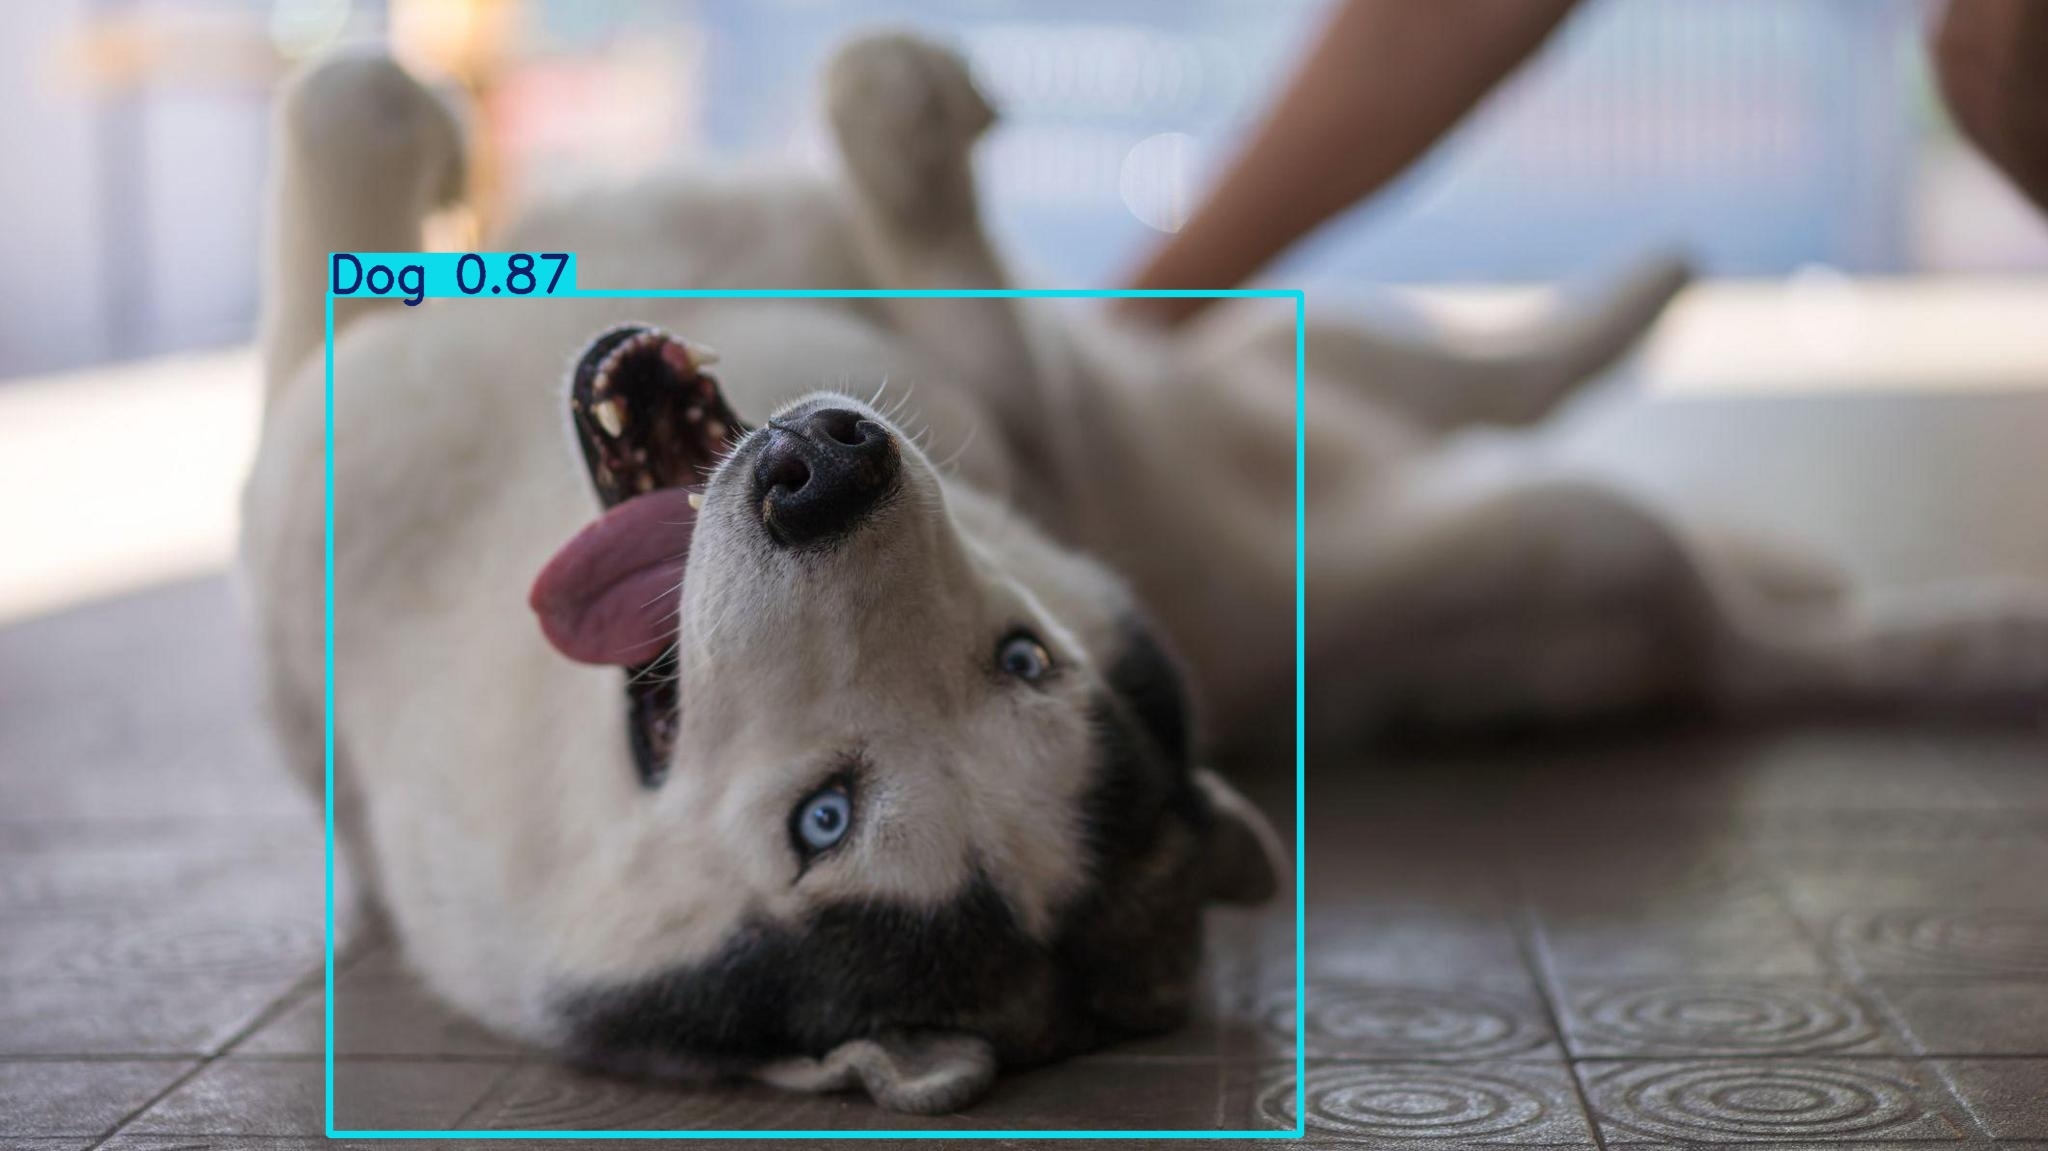

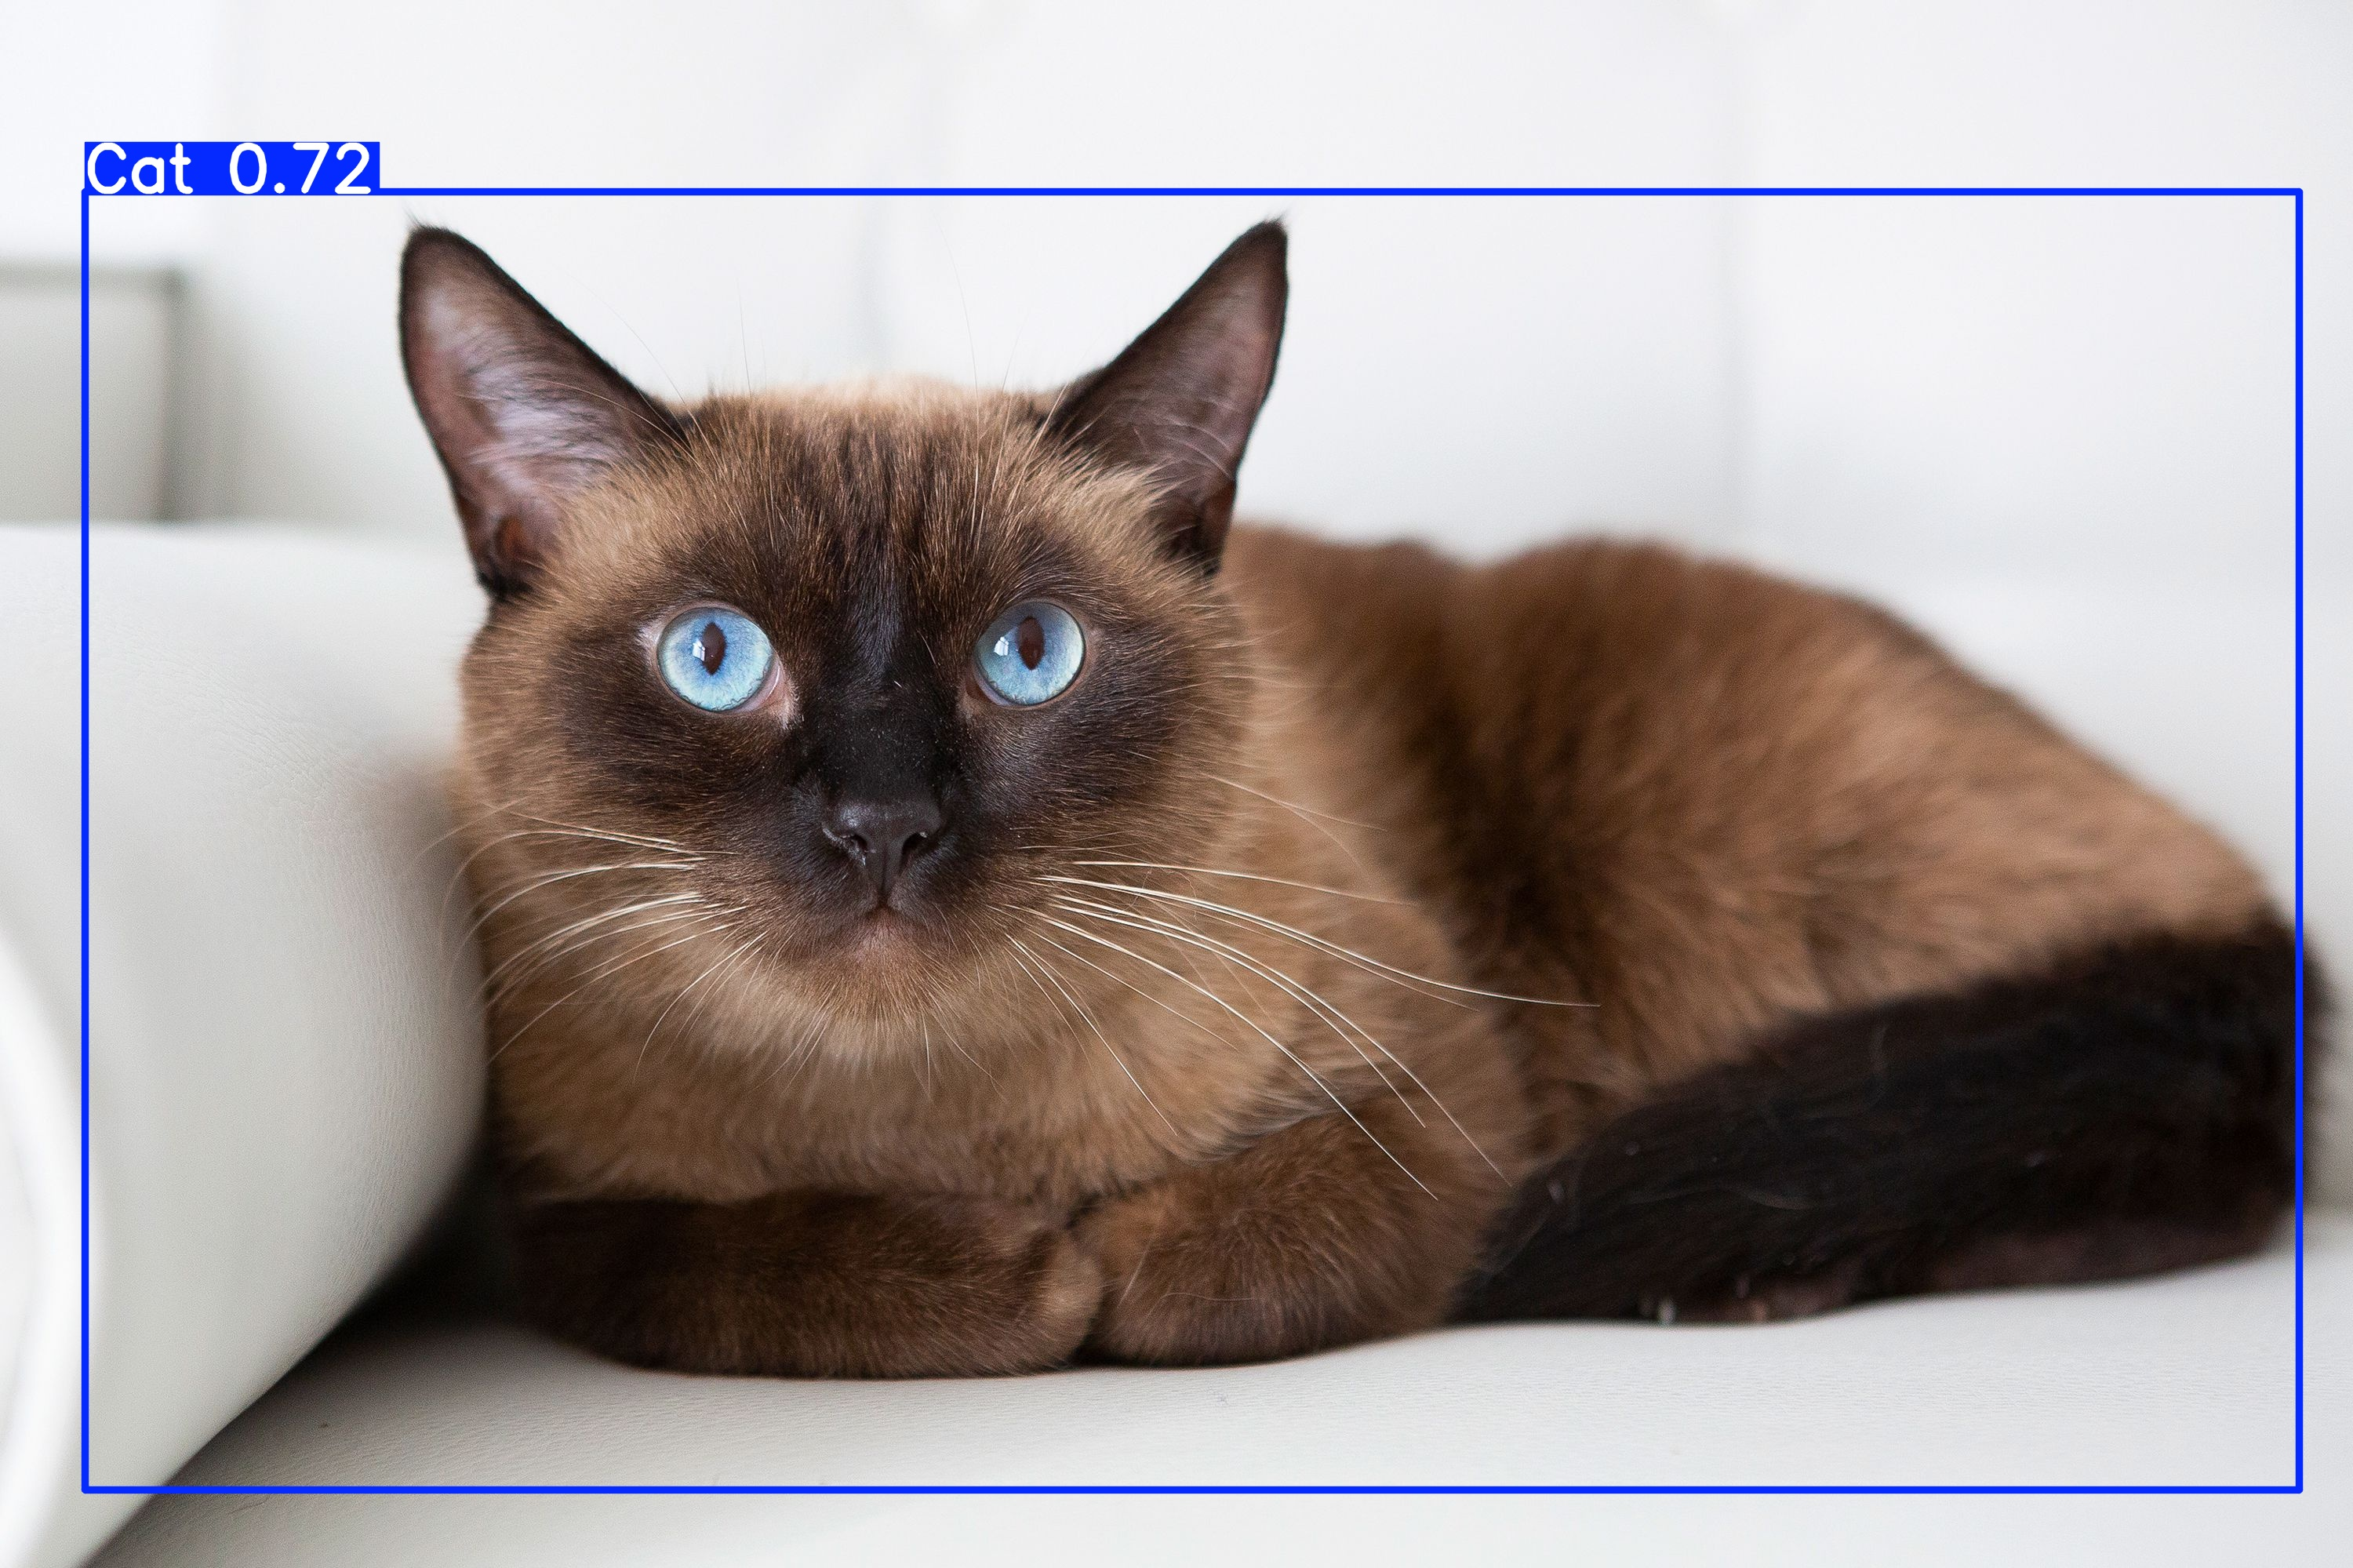

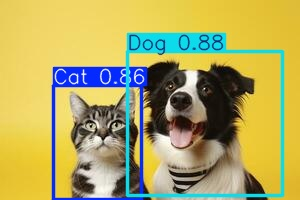

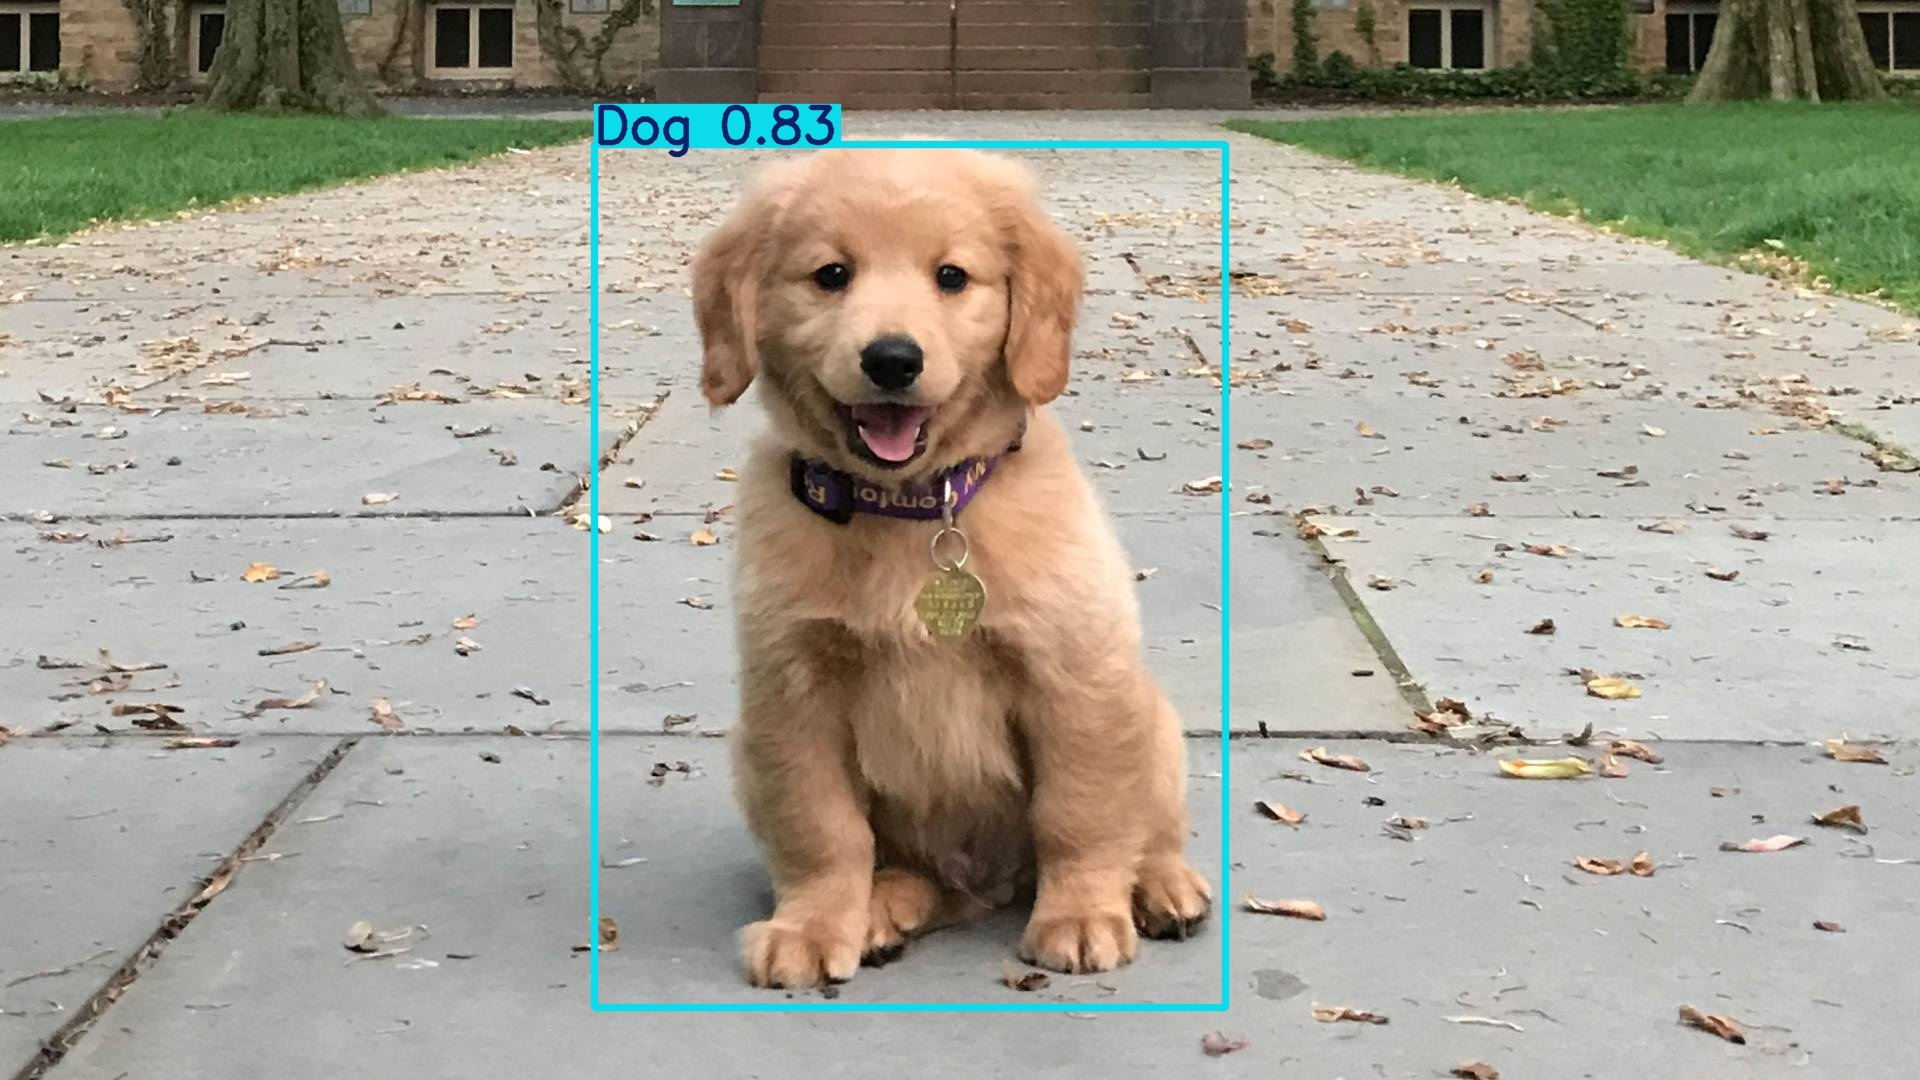

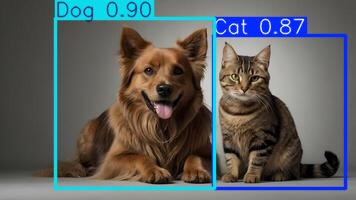

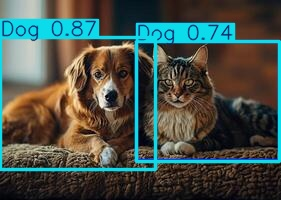

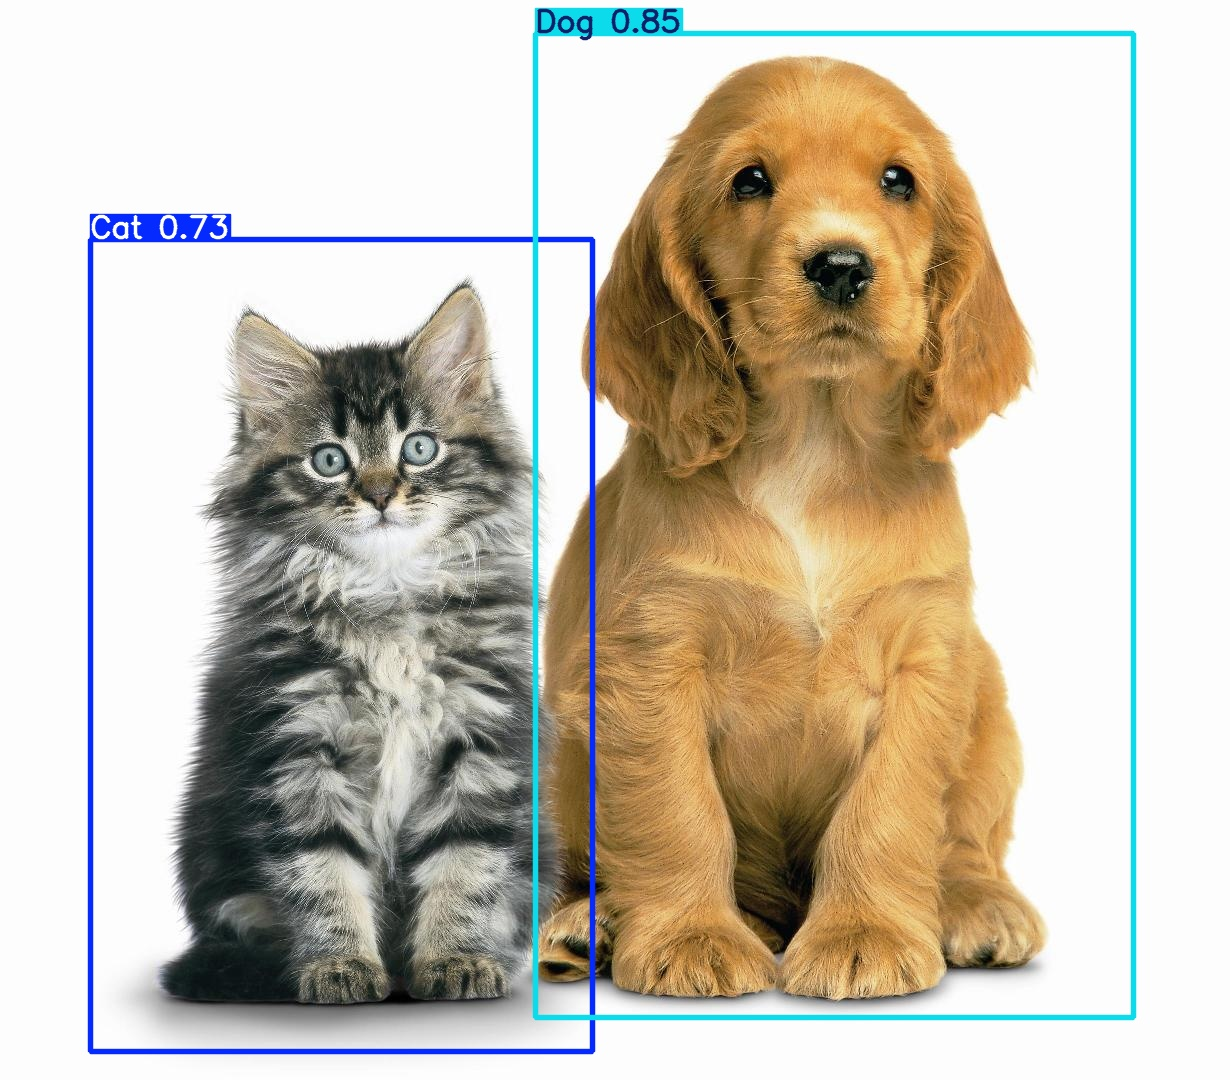

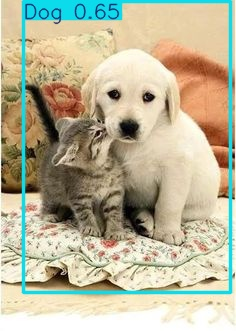

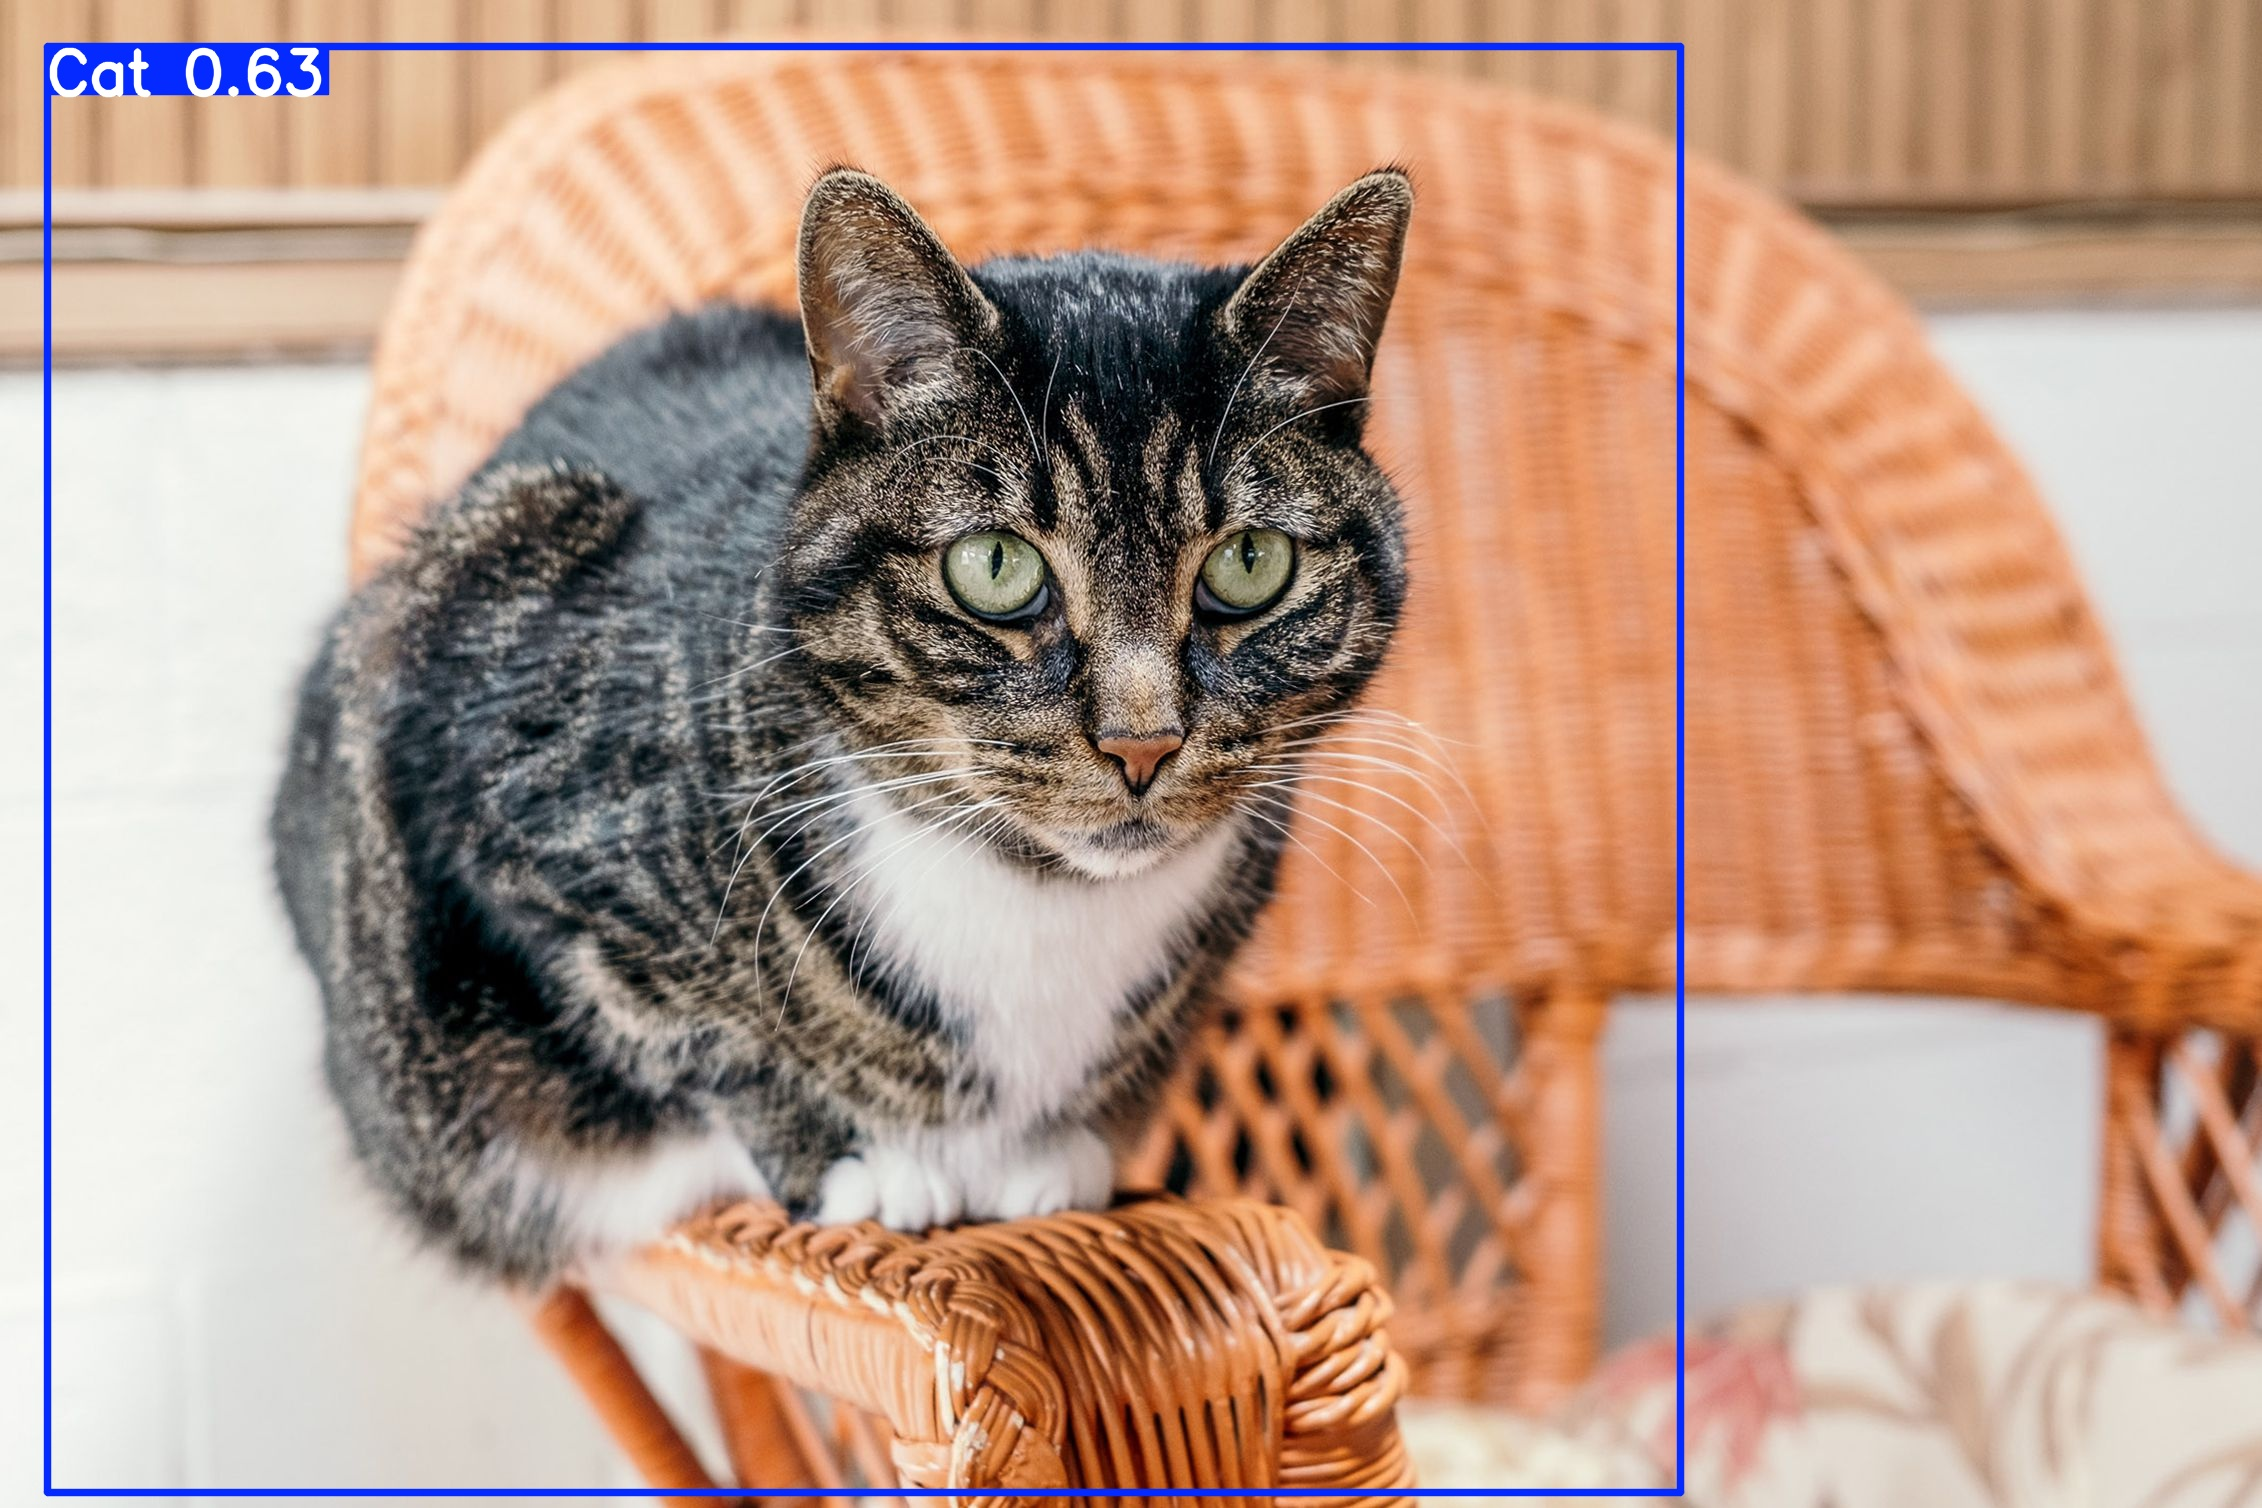

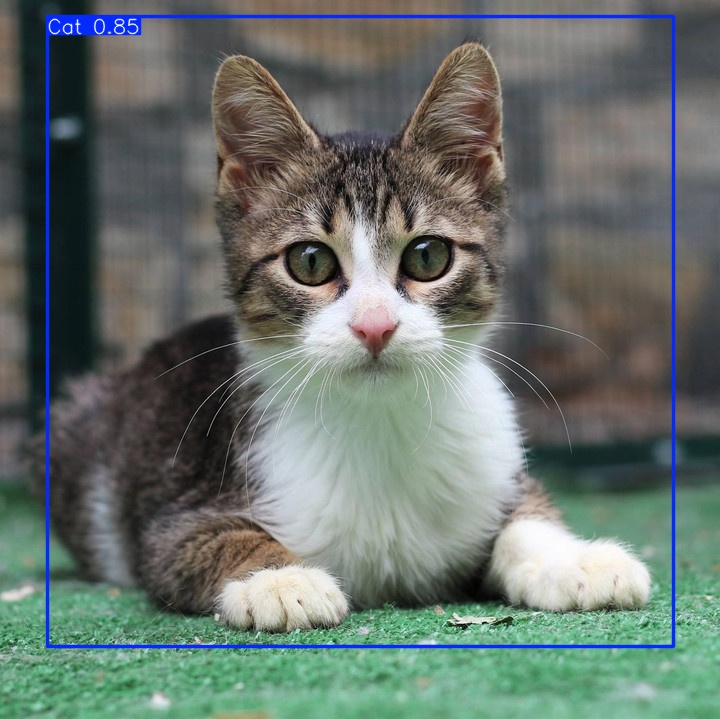

In [16]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')


##Download the model

In [17]:
# Create "my_model" folder to store model weights and train results
!mkdir /content/model
!cp /content/runs/detect/train/weights/best.pt /content/model/model.pt
!cp -r /content/runs/detect/train /content/model

# Zip into "my_model.zip"
%cd model
!zip /content/model.zip model.pt
!zip -r /content/model.zip train
%cd /content

/content/model
  adding: model.pt (deflated 8%)
  adding: train/ (stored 0%)
  adding: train/weights/ (stored 0%)
  adding: train/weights/last.pt (deflated 8%)
  adding: train/weights/best.pt (deflated 8%)
  adding: train/R_curve.png (deflated 15%)
  adding: train/results.csv (deflated 60%)
  adding: train/val_batch0_labels.jpg (deflated 20%)
  adding: train/events.out.tfevents.1742900408.4d3892327926.1747.0 (deflated 90%)
  adding: train/train_batch2.jpg (deflated 6%)
  adding: train/labels_correlogram.jpg (deflated 46%)
  adding: train/train_batch300.jpg (deflated 14%)
  adding: train/P_curve.png (deflated 14%)
  adding: train/results.png (deflated 5%)
  adding: train/args.yaml (deflated 53%)
  adding: train/train_batch1.jpg (deflated 6%)
  adding: train/labels.jpg (deflated 41%)
  adding: train/train_batch302.jpg (deflated 11%)
  adding: train/confusion_matrix.png (deflated 41%)
  adding: train/val_batch0_pred.jpg (deflated 19%)
  adding: train/train_batch0.jpg (deflated 6%)
  addin

In [18]:
# This takes forever for some reason, you can also just download the model from the sidebar
from google.colab import files

files.download('/content/model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>